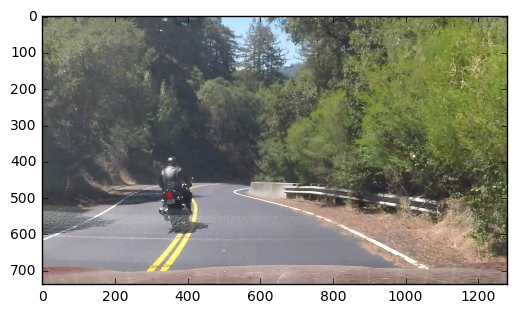

0
1
1
1
3
3
3
4
4


In [27]:
%matplotlib inline

from ipywidgets import *
from matplotlib import pyplot as plt
from glob import glob
from PIL import Image
import numpy as np
import cv2

for i in glob('test_images2/*'):
    img = np.asarray(Image.open(i))
    plt.imshow(im)
    h, w = img.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    break
    

def plot(amplitude, color):
    fig, ax = plt.subplots(figsize=(4, 3),
                           subplot_kw={'axisbg':'#EEEEEE',
                                       'axisbelow':True})
    ax.grid(color='w', linewidth=2, linestyle='solid')
    x = np.linspace(0, 10, 1000)
    ax.plot(x, amplitude * np.sin(x), color=color,
            lw=5, alpha=0.4)
    ax.set_xlim(0, 10)
    ax.set_ylim(-1.1, 1.1)
    return fig
 
from IPython.display import display
button = widgets.Button(description="Click Me!")
display(button)

def on_button_clicked(b):
    print("Button clicked.")

button.on_click(on_button_clicked)
    
a = IntSlider()
a.observe(lambda v: print(a.value))
display(a)
